In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deep_gravity_utils as dgu
import ipdb

In [2]:
dgu.setup_seed(12)

# Gravity Model Inspired Neural Network (FC)

In [5]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [4]:
# Model specification
class DeepGravityNet(nn.Module):
    def __init__(self, inp_dim, hid_dim=256, out_dim=1, dropout_p=0.35):
        super(DeepGravityNet, self).__init__()
        
        self.deep_graivty_fc1 = nn.Sequential(
            nn.Linear(inp_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.deep_graivty_fc2 = nn.Sequential(
            
            nn.Linear(hid_dim, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, inp_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        self.out_fc = nn.Sequential(
            nn.Linear(inp_dim, 1),
            nn.ReLU()
        )
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = nn.BatchNorm1d(x.shape[1], device=device)(x)
        y = self.deep_graivty_fc1(x)
        y = nn.BatchNorm1d(y.shape[1], device=device)(y)
        # shape of "x" here = [batchsize, sequence_len, 256]
        y = self.deep_graivty_fc2(y)
        y += x
        y = self.out_fc(y)
        return y
    

## Reading data (annually)

In [6]:
OD = pd.read_csv('./data/OD.csv', index_col=0).iloc[:48, :48]
data_X_org = pd.read_csv('./data/data_X.csv', index_col=0).iloc[:48, :]
connectivity = pd.read_csv('./data/connectivity.csv', index_col=0)
stops = pd.read_csv('./data/stops_order.csv', index_col=0).iloc[:48, :]


In [7]:
def get_data_X(dest):
    data_X_df = data_X_org.copy()
    # dest means the destination station name
    dest_data = data_X_df.loc[data_X_df['nearest station']==dest]
    dest_lat = data_X_df.loc[data_X_df['nearest station']==dest, 'INTPTLAT'].values
    dest_lon = data_X_df.loc[data_X_df['nearest station']==dest, 'INTPTLON'].values
    
    dist_lst = []
    for i in data_X_df.index:
        org_lat = data_X_df.loc[i, 'INTPTLAT']
        org_lon = data_X_df.loc[i, 'INTPTLON']
        dist = np.sqrt((dest_lat-org_lat)**2 + (dest_lon-org_lon)**2) * 111  # km
        dist_lst.append(dist[0])
    
    data_X_df.insert(2, 'dist', dist_lst)
    
    data_X_df = data_X_df.drop(['INTPTLAT', 'INTPTLON', 'nearest station'], axis=1)
    data_X = data_X_df.to_numpy()
    
    dest_data = dest_data.drop(['INTPTLAT', 'INTPTLON', 'nearest station'], axis=1)
    dest_data = dest_data.to_numpy().reshape(1, -1)
    dest_data_mat = np.repeat(dest_data, data_X.shape[0], axis=0)
    
    # concatenate data_X and dest_data_mat
    data_X = np.concatenate([data_X, dest_data_mat], axis=1)
        
    return data_X

In [8]:
def get_data_X_for_all_stops(stops):
    # stops should be a list
    data_X = get_data_X(stops[0])
    data_y = OD.loc[:, stops[0]].to_numpy().reshape(-1, 1)
    data_y = (data_y - data_y.min()) / (data_y.max() - data_y.min())
    
    for i in stops[1:]:
        data_X = np.concatenate([data_X, get_data_X(i)], axis=0)
        
        y = OD.loc[:, i].to_numpy().reshape(-1, 1)
        y = (y - y.min()) / (y.max() - y.min())
        data_y = np.concatenate([data_y, y], axis=0)
    
    # normalize
    data_X = (data_X - data_X.min()) / (data_X.max() - data_X.min())
#     data_y = (data_y - data_y.min()) / (data_y.max() - data_y.min())
    
    return data_X, data_y

In [9]:
# annual data
data_X, data_y = get_data_X_for_all_stops(list(stops['stop']))
print(data_X.shape)
print(data_y.shape)

(2304, 37)
(2304, 1)


In [10]:
# Initialization of hyper parameters
inp_dim = data_X.shape[-1]
print('Input dimension is %i'%inp_dim)

Input dimension is 37


## Train the model

In [11]:
# #############################
# Preparing data for PyTorch
# #############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prop = 0.7
l = int(data_X.shape[0]*prop)

X_train = torch.tensor(data_X[:l, :], dtype=torch.float32).to(device)
y_train = torch.tensor(data_y[:l, :], dtype=torch.float32).to(device)
X_val = torch.tensor(data_X[l:, :], dtype=torch.float32).to(device)
y_val = torch.tensor(data_y[l:, :], dtype=torch.float32).to(device)

batch_size = 2500
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)

iter_train = iter(loader_train)


In [12]:
# Train the model by inputing 
# [land use data and trip data (demand at each region)] 
# to the model, then output one column of OD
model = DeepGravityNet(inp_dim).to(device)
loss_func = nn.MSELoss()
loss_set_train = []
loss_set_val = []


In [13]:
optimizer = optim.Adam(model.parameters())

In [14]:
model.train()

epochs = 1000

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X, y = iter_train.next()
        except:
            iter_train = iter(loader_train)
            X, y = iter_train.next()
        
        out = model(X)
#         ipdb.set_trace()
        loss = loss_func(out, y)

        out_val = model(X_val)
#         ipdb.set_trace()
        loss_val = loss_func(out_val, y_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_set_val.append(loss_val.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0   success, val loss:0.065558, train loss:0.080867
Epoch 50   success, val loss:0.057952, train loss:0.067341
Epoch 100   success, val loss:0.018936, train loss:0.022522
Epoch 150   success, val loss:0.014685, train loss:0.017267
Epoch 200   success, val loss:0.013888, train loss:0.014671
Epoch 250   success, val loss:0.012289, train loss:0.011553
Epoch 300   success, val loss:0.015399, train loss:0.010935
Epoch 350   success, val loss:0.013943, train loss:0.009481
Epoch 400   success, val loss:0.012534, train loss:0.008208
Epoch 450   success, val loss:0.016872, train loss:0.007882
Epoch 500   success, val loss:0.013402, train loss:0.006911
Epoch 550   success, val loss:0.016386, train loss:0.007052
Epoch 600   success, val loss:0.016561, train loss:0.006793
Epoch 650   success, val loss:0.014937, train loss:0.006302
Epoch 700   success, val loss:0.017413, train loss:0.005606
Epoch 750   success, val loss:0.013638, train loss:0.005372
Epoch 800   success, val loss:0.015573, tra

In [15]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

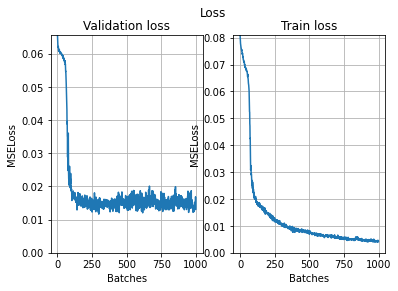

In [16]:
plot_loss(loss_set_val, loss_set_train, 'Loss')

In [18]:
# torch.save(model.state_dict(), './models/model_48stations.pth')


## Preliminary visualization of the prediction upon the validation dataset

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prop = 0.7
l = int(data_X.shape[0]*prop)

X_val = torch.tensor(data_X[l:, :], dtype=torch.float32).to(device)
y_val = torch.tensor(data_y[l:, :], dtype=torch.float32).to(device)

model = DeepGravityNet(inp_dim).to(device)
model.load_state_dict(torch.load('./models/model_48stations.pth'))
model.eval()

out_val = model(X_val)

In [20]:
summary(model) 

Layer (type:depth-idx)                   Param #
DeepGravityNet                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       9,728
│    └─LeakyReLU: 2-2                    --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       65,792
│    └─LeakyReLU: 2-5                    --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       65,792
│    └─LeakyReLU: 2-8                    --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      65,792
│    └─LeakyReLU: 2-11                   --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      65,792
│    └─LeakyReLU: 2-14                   --
│    └─Dropout: 2-15                     --
├─Sequential: 1-2                        --
│    └─Linear: 2-16                      32,896
│    └─LeakyReLU: 2-17                   --
│    └─Dropout: 2-18                     --
│   

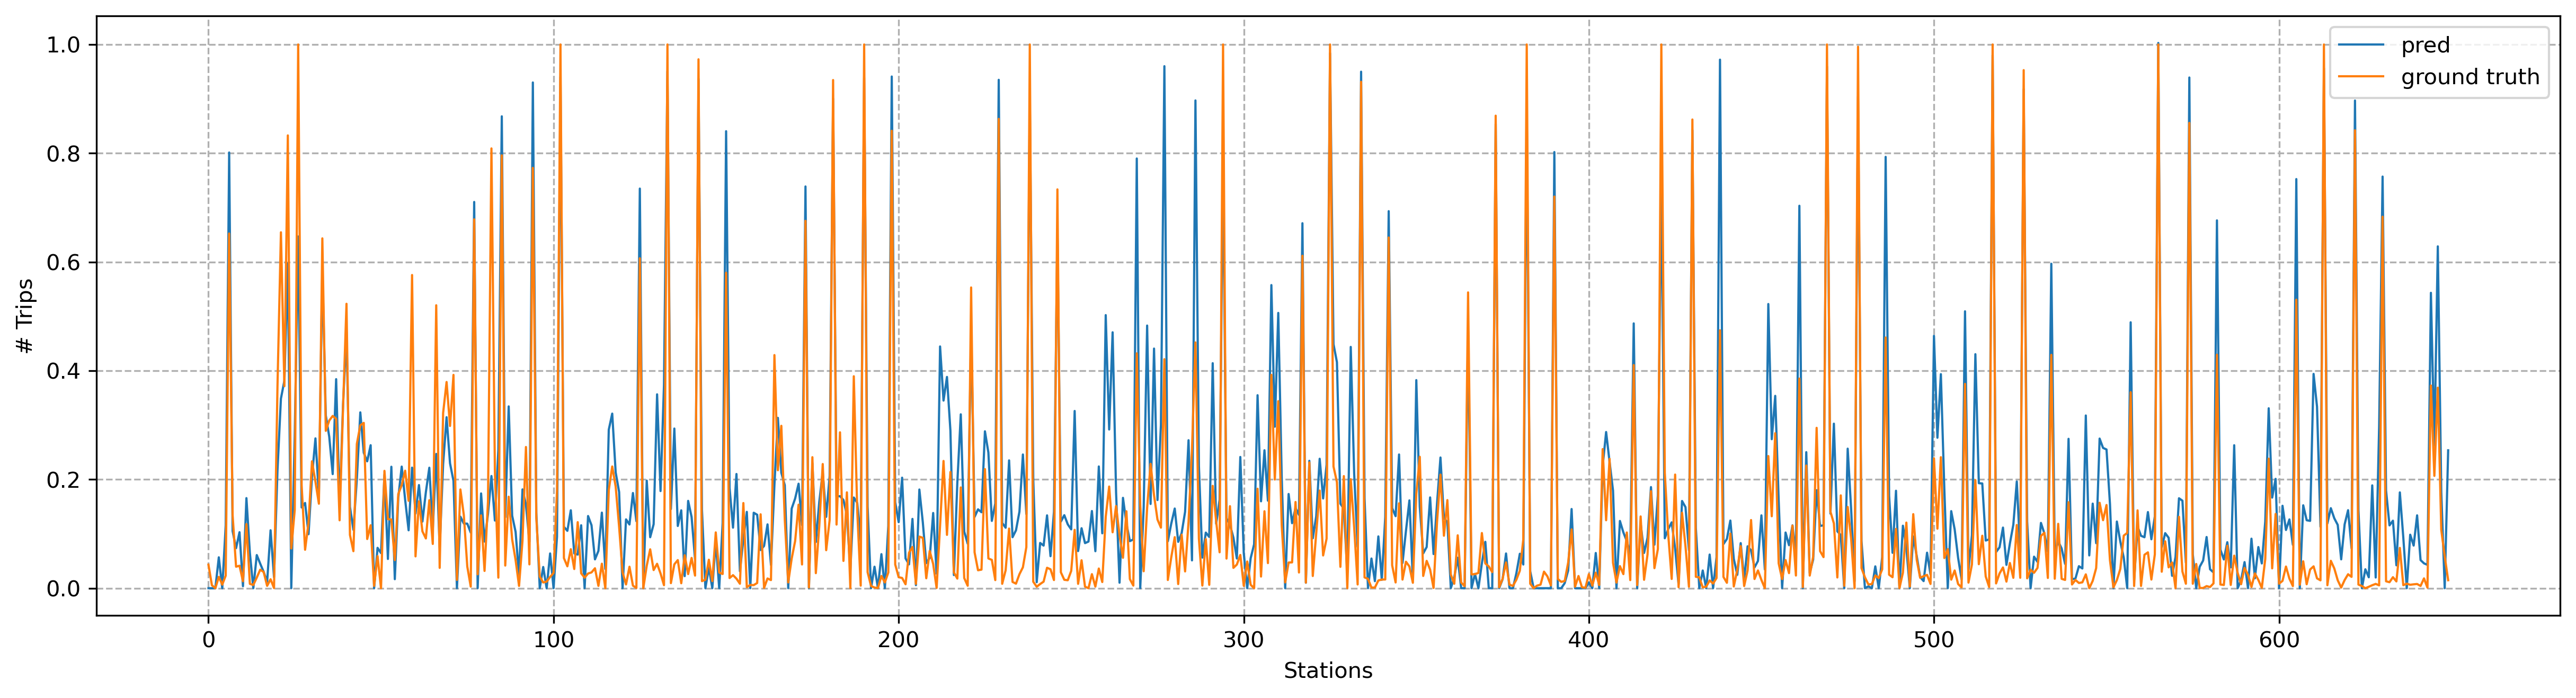

In [21]:
plt.figure(figsize=[20,5], dpi=300)
plt.plot(out_val.cpu().detach().numpy()[:650, 0], label='pred', lw=1)
plt.plot(y_val.cpu().detach().numpy()[:650, 0], label='ground truth', lw=1)
plt.xlabel('Stations')
plt.ylabel('# Trips')
plt.legend()
plt.grid(ls='--')

In [22]:
# Input the data from the Bay area to evaluate
# whether the model is practical

In [23]:
pred = out_val.cpu().detach().numpy()[:650, :]
labels = y_val.cpu().detach().numpy()[:650, :]

m = 0.1

print('The mae loss is %.4f'%dgu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%dgu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%dgu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%dgu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%dgu.nmae_loss_func(pred, labels, m))



The mae loss is 0.1113
The mape loss is 3.9722
The smape loss is 0.7475
The nrmse loss is 0.1417
The nmae loss is 0.1114


In [24]:
def get_CPC(pred, labels):
    res_min = np.concatenate([pred, labels], axis=1).min(axis=1).flatten()
    CPC = np.sum(res_min)*2 / (np.sum(pred) + np.sum(labels))
    return CPC

In [25]:
print('CPC is %.5f'%get_CPC(pred, labels))

CPC is 0.74343


# Visualization of trips on map

In [26]:
import geopandas as gpd

In [27]:
data_X_all = gpd.read_file('./data/data_X_all.shp')

In [28]:
data_X_all.head(2)

,GEOID,INTPTLAT,INTPTLON,TotPop,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,...,D4C,D4D,D5AR,D5AE,NatWalkInd,COUNTYID,if_keep,nearest st,transit di,geometry
0,06001983200,37.804224,-122.27715,11084.0,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",1664.0,2208.0,...,71.028333,707.012491,1891149.0,1455141.0,16.972222,06001,1.0,12TH,0.895287,"POLYGON ((-122.28374 37.79480, -122.28343 37.7..."
1,06075020500,37.769279,-122.43602,142973.0,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",20505.0,29075.0,...,30.318892,697.115918,16339411.0,11103193.0,16.600806,06075,1.0,16TH,2.424009,"POLYGON ((-122.43467 37.75611, -122.43564 37.7..."


In [29]:
bart_coor = pd.read_csv('./data/station-coor.csv', index_col=0)
bart_coor.head(2)

,abbr,lat,lon
0,12TH,37.803768,-122.271450
1,16TH,37.765062,-122.419694


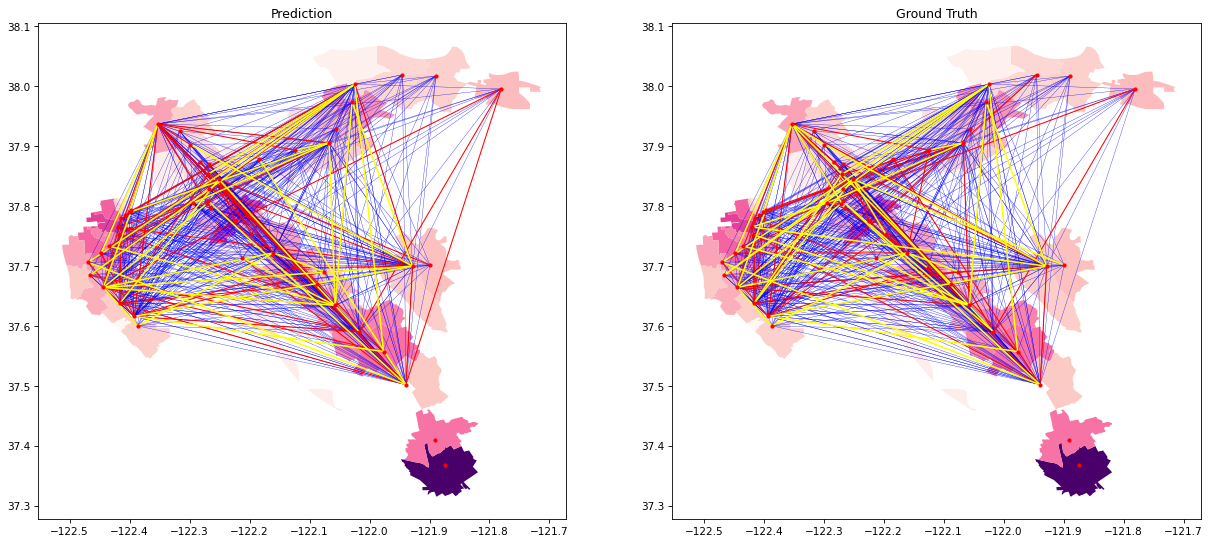

In [30]:
fig = plt.figure(figsize=[20, 10], dpi=75)
ax0 = fig.add_subplot(121)
ax0.set_title('Prediction')
ax1 = fig.add_subplot(122)
ax1.set_title('Ground Truth')

data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')
data_X_all.plot(column='TotPop', ax=ax1, cmap='RdPu')

# plot trips
num_pred_stations = pred.shape[0] // 50  # 50 means that there are 50 stations in total
pred_stations = stops.iloc[-num_pred_stations:, 0]

low_lon_pred_dest = []
low_lat_pred_dest = []
mid_lon_pred_dest = []
mid_lat_pred_dest = []
high_lon_pred_dest = []
high_lat_pred_dest = []
low_lon_pred_origin = []
low_lat_pred_origin = []
mid_lon_pred_origin = []
mid_lat_pred_origin = []
high_lon_pred_origin = []
high_lat_pred_origin = []

low_lon_labels_dest = []
low_lat_labels_dest = []
mid_lon_labels_dest = []
mid_lat_labels_dest = []
high_lon_labels_dest = []
high_lat_labels_dest = []
low_lon_labels_origin = []
low_lat_labels_origin = []
mid_lon_labels_origin = []
mid_lat_labels_origin = []
high_lon_labels_origin = []
high_lat_labels_origin = []

for i in pred_stations.index:
    station_dest = pred_stations.loc[i]
    for j in stops.index:
        station_origin = stops.loc[j, 'stop']
        
        lon_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lon'].values[0]
        lat_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lat'].values[0]
        lon_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lon'].values[0]
        lat_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lat'].values[0]
        
        dest_ind = i-34
        origin_ind = j+1
        trip_ind = dest_ind*origin_ind - 1
        
        if pred[trip_ind]<0.3:
            low_lon_pred_dest.append(lon_dest)
            low_lat_pred_dest.append(lat_dest)
            low_lon_pred_origin.append(lon_origin)
            low_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'b', lw=0.1)
        elif pred[trip_ind]>=0.3 and pred[trip_ind]<0.6:
            mid_lon_pred_dest.append(lon_dest)
            mid_lat_pred_dest.append(lat_dest)
            mid_lon_pred_origin.append(lon_origin)
            mid_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'red', lw=0.6)
        elif pred[trip_ind]>=0.6:
            high_lon_pred_dest.append(lon_dest)
            high_lat_pred_dest.append(lat_dest)
            high_lon_pred_origin.append(lon_origin)
            high_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'yellow', lw=2)
        
        if labels[trip_ind]<0.3:
            low_lon_labels_dest.append(lon_dest)
            low_lat_labels_dest.append(lat_dest)
            low_lon_labels_origin.append(lon_origin)
            low_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'b', lw=0.1)
        elif labels[trip_ind]>=0.3 and labels[trip_ind]<0.6:
            mid_lon_labels_dest.append(lon_dest)
            mid_lat_labels_dest.append(lat_dest)
            mid_lon_labels_origin.append(lon_origin)
            mid_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'red', lw=0.6)
        elif labels[trip_ind]>=0.6:
            high_lon_labels_dest.append(lon_dest)
            high_lat_labels_dest.append(lat_dest)
            high_lon_labels_origin.append(lon_origin)
            high_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'yellow', lw=2)

for i in range(len(low_lon_pred_dest)):
    ax0.plot([low_lon_pred_origin[i], low_lon_pred_dest[i]], [low_lat_pred_origin[i], low_lat_pred_dest[i]], 'b', lw=0.3)
    
for i in range(len(mid_lon_pred_dest)):
    ax0.plot([mid_lon_pred_origin[i], mid_lon_pred_dest[i]], [mid_lat_pred_origin[i], mid_lat_pred_dest[i]], 'red', lw=1)
    
for i in range(len(high_lon_pred_dest)):
    ax0.plot([high_lon_pred_origin[i], high_lon_pred_dest[i]], [high_lat_pred_origin[i], high_lat_pred_dest[i]], 'yellow', lw=1.5)

for i in range(len(low_lon_labels_dest)):
    ax1.plot([low_lon_labels_origin[i], low_lon_labels_dest[i]], [low_lat_labels_origin[i], low_lat_labels_dest[i]], 'b', lw=0.3)
    
for i in range(len(mid_lon_labels_dest)):
    ax1.plot([mid_lon_labels_origin[i], mid_lon_labels_dest[i]], [mid_lat_labels_origin[i], mid_lat_labels_dest[i]], 'red', lw=1)
    
for i in range(len(high_lon_labels_dest)):
    ax1.plot([high_lon_labels_origin[i], high_lon_labels_dest[i]], [high_lat_labels_origin[i], high_lat_labels_dest[i]], 'yellow', lw=1.5)



# plot stations
for i in bart_coor.index:
    lon = bart_coor.loc[i, 'lon']
    lat = bart_coor.loc[i, 'lat']
    ax0.plot(lon, lat, 'r.')
    ax1.plot(lon, lat, 'r.')



In [87]:
# fig.savefig('./outputs/comp.jpg', dpi=700)